In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


fashion


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


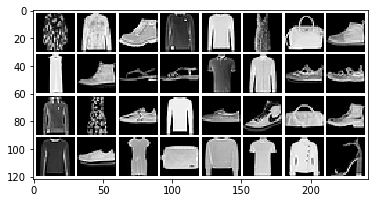

torch.Size([32, 1, 28, 28])


In [4]:
### LOAD DATA ###

dataset = 'fashion'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft ** 2, -1))

plot_grid(sample)
print(sample_magnitudes.shape)

In [5]:
def poisson_noise(magn, device, alpha=1):
    intens = magn ** 2
    alpha_2 = alpha ** 2
    lmd = intens / alpha_2
    intens_noise = alpha_2 * torch.distributions.poisson.Poisson(lmd).sample()
    magn_noise = torch.sqrt(intens_noise)
    return magn_noise


def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags


def test_generator(model, device, testloader, alpha, one_batch=False):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        data = data.to(device=device)
        magn = poisson_noise(calc_mags(data), device, alpha)
        ouput = model(magn)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
        if one_batch: break
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [8]:
### LOAD MODEL ####

gen = models.FCNet(imsize=imsize, h=2048)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/models/FCnet_Fashion/FCNet2048Fashion_6.sd", map_location={'cuda:1': device.__str__()}));
gen.eval();

Version 0.4


In [50]:
# Calculate test predictions #

alpha = 50.0

test_original, test_predicted = test_generator(gen, device, dataloader['test'], alpha)
print(test_predicted.shape)

(8000, 1, 28, 28)


In [51]:
### CACHE RESULTS ###

import pickle
pickle.dump(test_original, open("/home/shared/phase-retrieval/test/FCnet_Fashion/original_alpha{}.p".format(alpha), "wb"))
pickle.dump(test_predicted, open("/home/shared/phase-retrieval/test/FCnet_Fashion/predicted_alpha{}.p".format(alpha), "wb"))

In [52]:
### LOAD RESULTS ###
import pickle

test_original = pickle.load(open("/home/shared/phase-retrieval/test/FCnet_Fashion/original_alpha{}.p".format(alpha), "rb"))
test_predicted = pickle.load(open("/home/shared/phase-retrieval/test/FCnet_Fashion/predicted_alpha{}.p".format(alpha), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


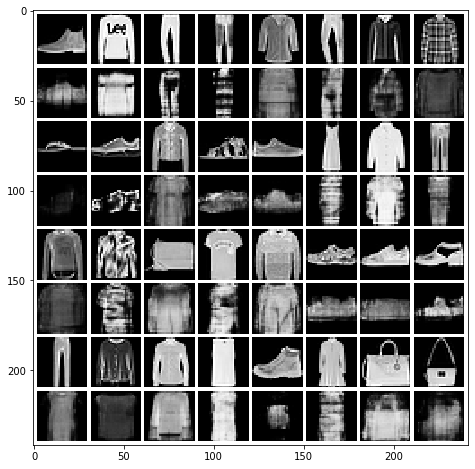

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


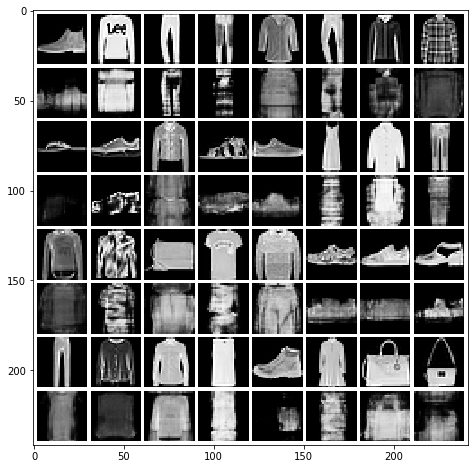

In [53]:
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/e2e/fashion/FCNet2048Fashion_1024_alpha{}.png".format(alpha))

print("Registered:")
results_reg = register_croco(test_predicted[:32], test_original[:32])
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/e2e/fashion/FCNet2048Fashion_1024_alpha{}.png".format(alpha))

In [54]:
# Benchmark test predictions #

benchmark(pred=test_predicted[:1024], true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.06332095424113504, std: 0.03283328632949496
  MAE: 0.14963588446335052, std: 0.048165160679157035
  SSIM: 0.35870991329258795, std: 0.1556971004433715
  Sharpness: 0.1705934663738221, std: 0.043685596699354005
  PhCo-MSE: 0.09429157048543857, std: 0.08374928738089657
  PhCo-MAE: 0.1922685624413134, std: 0.10590663556131859
  PhCo-SSIM: 0.3008648117833908, std: 0.18998348645895857
  CroCo-MSE: 0.05112322611512354, std: 0.024053687539174713
  CroCo-MAE: 0.13376249476277735, std: 0.03929086285588523
  CroCo-SSIM: 0.4225811638206243, std: 0.13687897156726045

Magnitude error:
  MSE Magnitude: 19.266972842367544, std: 9.357428201563954

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.06332 | 0.1496 | 0.3587 | 0.1706 | 0.09429 | 0.1923 | 0.3009 | 0.05112 | 0.1338 | 0.4226 | 19.27 |


## Evaluation for different FC  (1024 samples)

| alpha | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 0.01 | 0.01536 | 0.05631 | 0.7742 | 0.1006 | 0.01505 | 0.05625 | 0.7797 | 0.01280 | 0.05256 | 0.7939 | 3.576 |
| 0.03 | 0.01536 | 0.05630 | 0.7742 | 0.1006 | 0.01501 | 0.05617 | 0.7801 | 0.01280 | 0.05255 | 0.7940 | 3.576 |
| 0.1 | 0.01536 | 0.05631 | 0.7742 | 0.1006 | 0.01501 | 0.05618 | 0.7800 | 0.01280 | 0.05256 | 0.7939 | 3.577 |
| 0.3 | 0.01539 | 0.05639 | 0.7738 | 0.1007 | 0.01504 | 0.05614 | 0.7802 | 0.01281 | 0.05263 | 0.7936 | 3.587 |
| 1.0 | 0.01549 | 0.05686 | 0.7715 | 0.1012 | 0.01488 | 0.05647 | 0.7774 | 0.01294 | 0.05313 | 0.7909 | 3.658 |
| 3.0 | 0.01691 | 0.06113 | 0.7491 | 0.1053 | 0.01665 | 0.06120 | 0.7535 | 0.01398 | 0.05680 | 0.7722 | 4.206 |
| 10.0 | 0.02625 | 0.08409 | 0.6385 | 0.1276 | 0.03201 | 0.09310 | 0.6180 | 0.02219 | 0.07844 | 0.6673 | 7.695 |
| 25.0 | 0.04387 | 0.1183 | 0.4793 | 0.1534 | 0.06520 | 0.1486 | 0.4229 | 0.03675 | 0.1087 | 0.5237 | 13.33 |
| 50.0 | 0.06332 | 0.1496 | 0.3587 | 0.1706 | 0.09429 | 0.1923 | 0.3009 | 0.05112 | 0.1338 | 0.4226 | 19.27 |